
# Bell‑202 FSK: C `demodFSK()` Test
1) Generate FSK (mark=1200 Hz, space=2200 Hz) and quantize to 12‑bit ADC samples.  
2) Compile your **`demod_fsk.c`** into a shared library.  
3) Call `demodFSK(uint16_t)` per sample and plot **input vs output**.


In [36]:
# Build libdemod.so from demod_fsk.c and fir_coefs.h
!gcc -std=c11 -O1 -march=native -fPIC -shared demod_fsk.c -o libdemod.so -lm

print("Compiled libdemod.so")

Compiled libdemod.so


In [37]:
import numpy as np
import ctypes
from matplotlib import pyplot as plt

print("Libraries loaded")

Libraries loaded


In [38]:
# Load the shared library
libdemod = ctypes.CDLL('./libdemod.so')

# Define function signature: float demodFSK(uint16_t adc_value)
libdemod.demodFSK.argtypes = (ctypes.c_uint16,)
libdemod.demodFSK.restype = ctypes.c_float

print("demodFSK() loaded")

demodFSK() loaded


In [39]:
# --- TP3 Parameters ---
Fs       = 12000        # Sampling frequency [Hz]
bps      = 1200         # Bit rate [bits/s]
F_MARK   = 1200         # '1' → 1200 Hz
F_SPACE  = 2200         # '0' → 2200 Hz
amp      = 1.0          # Amplitude (normalized)

# --- Bitstream (from PDF Fig. 7) ---
#bits_str = "0000111000000000011111"
bits_str = "110111111111111100101010101"  # any pattern

print(f"Bitstream: {bits_str[:30]}")

Bitstream: 110111111111111100101010101


In [40]:
# Samples per bit
Ns = int(round(Fs / bps))           # → 10
N  = Ns * len(bits_str)             # Total samples
t  = np.arange(N) / Fs              # Time vector [s]

# Frequency per sample
bits = np.array([b == '1' for b in bits_str], dtype=bool)
freqs = np.where(np.repeat(bits, Ns), F_MARK, F_SPACE)

# Continuous phase FSK
phase = np.cumsum(2 * np.pi * freqs / Fs)
fsk_signal = amp * np.sin(phase)

# Quantize to 12-bit ADC (0–4095)
adc_bits = 12
adc_max = (1 << adc_bits) - 1
adc_signal = np.round((fsk_signal + 1.0) * 0.5 * adc_max).astype(np.uint16)

print(f"Generated {N} samples ({len(bits_str)} bits, {Ns} samples/bit)")

Generated 270 samples (27 bits, 10 samples/bit)


In [41]:
# Output buffer
d_output = np.zeros(N, dtype=np.float32)

print("Running demodFSK() on each ADC sample...")
for i in range(N):
    d_output[i] = libdemod.demodFSK(ctypes.c_uint16(adc_signal[i]))

print("Done.")

Running demodFSK() on each ADC sample...
Done.


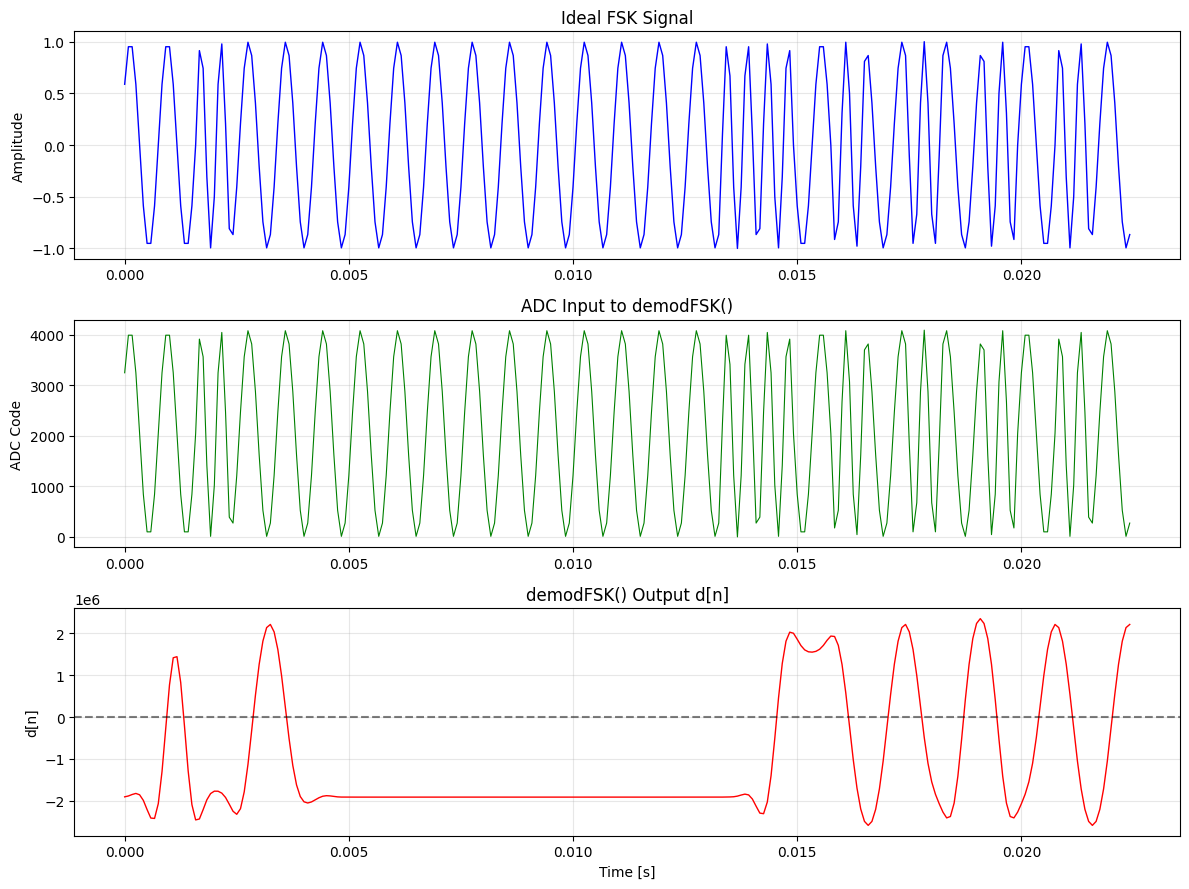

bitstreamReconstruction() and UART functions loaded
Running bitstreamReconstruction() on each d[n]...
UART Frame 1: 0 0 0 0 1 1 1 1 1 1 1
UART Frame 2: 0 1 1 1 1 1 1 1 1 1 1

Recovered 2 full UART frames.

Original Bitstream: 110111111111111100101010101


In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9))

# 1. Analog FSK
ax1.plot(t, fsk_signal, 'b-', linewidth=1)
ax1.set_title("Ideal FSK Signal")
ax1.set_ylabel("Amplitude")
ax1.grid(alpha=0.3)

# 2. ADC Input
ax2.plot(t, adc_signal, 'g-', linewidth=0.8)
ax2.set_title("ADC Input to demodFSK()")
ax2.set_ylabel("ADC Code")
ax2.grid(alpha=0.3)

# 3. Demod Output
ax3.plot(t, d_output, 'r-', linewidth=1)
ax3.axhline(0, color='k', linestyle='--', alpha=0.5)
ax3.set_title("demodFSK() Output d[n]")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("d[n]")
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Add function signatures for bitstreamReconstruction, isDataReady, retrieveBitstream ---
libdemod.bitstreamReconstruction.argtypes = (ctypes.c_float,)
libdemod.bitstreamReconstruction.restype = None

libdemod.isDataReady.argtypes = ()
libdemod.isDataReady.restype = ctypes.c_bool

libdemod.retrieveBitstream.argtypes = ()
libdemod.retrieveBitstream.restype = ctypes.POINTER(ctypes.c_bool * 11)

print("bitstreamReconstruction() and UART functions loaded")

# --- Run demod + FSM on every sample ---
print("Running bitstreamReconstruction() on each d[n]...")
frames_recovered = []

for i in range(N):
    d = d_output[i]  # from previous cell
    libdemod.bitstreamReconstruction(ctypes.c_float(d))
    
    if libdemod.isDataReady():
        # Get pointer to 11-bit array
        bool_array_ptr = libdemod.retrieveBitstream()
        # Convert to Python list
        bits = [bool_array_ptr.contents[i] for i in range(11)]
        frames_recovered.append(bits)
        print(f"UART Frame {len(frames_recovered)}: {' '.join(['1' if b else '0' for b in bits])}")

print(f"\nRecovered {len(frames_recovered)} full UART frames.")

print(f"\nOriginal Bitstream: {bits_str[:30]}")